<a href="https://colab.research.google.com/github/taddbackus/capstone/blob/main/Working%20RNN/Data_Cleanup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import os
import numpy as np
import pandas as pd

# Geospatial processing packages
import geopandas as gpd

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Loading dataframe on current active/and closed coal mines

In [52]:
#join in overall info
# Read the GeoJSON file
mines = gpd.read_file('/content/drive/MyDrive/OSMRE_GEOMINE_GEOJSON.geojson')
mines = pd.DataFrame(mines)
mines = mines[['company',
               'coalmine_op_status',
               'mine_name',
               'permit_id',
               'national_id',
               'coal_bed_names',
               'inspectable_unit_status',
                'post_smcra',
               'reported_area',
               'permit_application_type',
               'permit_application_date',
               'permit_approval_date',
               'edit_date',
               'area_mine',
               'contour',
               'mountaintop',
               'steep_slope',
               'highwall',
               'auger',
               'contact']].drop_duplicates()

#replace empty strings with NAN
mines = mines.replace(r'^\s*$', np.nan, regex=True)


In [53]:
### Appending the number of unique companies per permit_id to dataframe
Company_check = mines[['permit_id', 'company']].groupby(['permit_id']).nunique().sort_values('company', ascending=False)
Company_check = Company_check.rename(columns={"company": "Number_company_to_permit_id"})
Company_check[Company_check['Number_company_to_permit_id']>1]
mines = pd.merge(mines, Company_check,  how='left', left_on=['permit_id'], right_on = ['permit_id'])

### Adding in State column to mines df
mines['State'] = mines['national_id'].str.slice(0, 2)
mines['State'].unique()
mines = mines[mines['State']. isin(['KY', 'TN', 'WV'])]
mines['State'] = mines['State'].str.lower()

In [54]:
mines['edit_month'] = mines['edit_date'].astype(str).str.slice(5, 7)
mines['edit_year'] = mines['edit_date'].astype(str).str.slice(0,4)
mines = mines.drop(columns='edit_date')
mines['permit_weekday'] = mines['permit_approval_date'].dt.day_name()
mines['permit_approval_month'] = mines['permit_approval_date'].astype(str).str.slice(5, 7)
mines['permit_approval_year'] = mines['permit_approval_date'].astype(str).str.slice(0,4)
mines = mines.drop(columns='permit_approval_date')
mines['permit_application_year'] =  mines['permit_application_date'].astype(str).str.slice(0,4)
mines = mines.drop(columns='permit_application_date')

In [55]:
mines.columns

Index(['company', 'coalmine_op_status', 'mine_name', 'permit_id',
       'national_id', 'coal_bed_names', 'inspectable_unit_status',
       'post_smcra', 'reported_area', 'permit_application_type', 'area_mine',
       'contour', 'mountaintop', 'steep_slope', 'highwall', 'auger', 'contact',
       'Number_company_to_permit_id', 'State', 'edit_month', 'edit_year',
       'permit_weekday', 'permit_approval_month', 'permit_approval_year',
       'permit_application_year'],
      dtype='object')

In [56]:
#mines = pd.get_dummies(mines, columns=['mountaintop'])
#mines = pd.get_dummies(mines, columns=['area_mine'])
#mines = pd.get_dummies(mines, columns=['highwall'])
#mines = pd.get_dummies(mines, columns=['steep_slope'])
#mines = pd.get_dummies(mines, columns=['coalmine_op_status'])


### Loading dataframes from google earth engine queries

In [57]:
directory_path = '/content/drive/MyDrive/Mines_Data/'
directory_files = os.listdir(directory_path)

df = pd.DataFrame()
z=0
for i in directory_files:
    df_file = pd.read_csv(os.path.join(directory_path, i), encoding = 'ISO-8859-1',low_memory=False)
    df_file['year'] = directory_files[z]
    df_file['year'] = df_file['year'].str.slice(3, 7)
    df_file['end_date'] = df_file['year']+'-07-31'
    df_file['start_date'] = df_file['year']+'-07-01'
    df_file['start_date'] = pd.to_datetime(df_file['start_date'])
    df_file['end_date'] = pd.to_datetime(df_file['end_date'])

    df_file['State'] = directory_files[z]
    df_file['State'] = df_file['State'].str.slice(0, 2)

    df = pd.concat([df, df_file])

    z+=1


### aggregating to averages of land class(the probability) classes

In [58]:
df[['orig_perm_id', 'start_date', 'mine_id', 'Company', 'State']].groupby([ 'State']).count().reset_index()


,State,orig_perm_id,start_date,mine_id,Company
0,ky,1269188,1269188,1269188,1269188
1,tn,14618,14618,14618,14618
2,wv,75001,75001,75001,75001


In [59]:
#mapping demo in python https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=SI5i7rboSGFL&uniqifier=2
# Read the downloaded file
#419bdf	water, #397d49	trees, #88b053	grass, #7a87c6	flooded_vegetation, #e49635	crops, #dfc35a	shrub_and_scrub, #c4281b	built, #a59b8f	bare, #b39fe1	snow_and_ice

label0 = df[['orig_perm_id', 'Company','mine_id','water', 'start_date', 'State']].groupby(['orig_perm_id', 'State','mine_id', 'start_date','Company']).mean().reset_index()
label1 = df[['orig_perm_id', 'Company','mine_id', 'trees', 'start_date', 'State']].groupby(['orig_perm_id', 'State','mine_id','start_date', 'Company']).mean().reset_index()
label2 = df[['orig_perm_id', 'Company','mine_id', 'grass', 'start_date', 'State']].groupby(['orig_perm_id', 'State','mine_id','start_date', 'Company']).mean().reset_index()
label3 = df[['orig_perm_id', 'Company','mine_id','flooded_vegetation', 'start_date', 'State']].groupby(['orig_perm_id', 'State','mine_id', 'start_date', 'Company']).mean().reset_index()
label4 = df[['orig_perm_id', 'Company','mine_id', 'crops', 'start_date', 'State']].groupby(['orig_perm_id', 'State', 'start_date','mine_id', 'Company']).mean().reset_index().drop_duplicates()
label5 = df[['orig_perm_id', 'Company','mine_id', 'shrub_and_scrub', 'start_date', 'State']].groupby(['orig_perm_id', 'State', 'start_date', 'mine_id','Company']).mean().reset_index()
label6 = df[['orig_perm_id', 'Company','mine_id', 'built', 'start_date', 'State']].groupby(['orig_perm_id', 'State', 'start_date','mine_id', 'Company']).mean().reset_index()
label7 = df[['orig_perm_id', 'Company','mine_id', 'bare', 'start_date', 'State']].groupby(['orig_perm_id', 'State', 'start_date','mine_id', 'Company']).mean().reset_index()
label8 = df[['orig_perm_id', 'Company','mine_id', 'snow_and_ice', 'start_date', 'State']].groupby(['orig_perm_id', 'State','start_date','mine_id', 'Company']).mean().reset_index()

label0 =label0.drop_duplicates()
label1 =label1.drop_duplicates()
label2 =label2.drop_duplicates()
label3 =label3.drop_duplicates()
label4 =label4.drop_duplicates()
label5 =label5.drop_duplicates()
label6 =label6.drop_duplicates()
label7 =label7.drop_duplicates()
label8 =label8.drop_duplicates()

group_df = df[['orig_perm_id', 'start_date', 'mine_id', 'Company', 'State']].groupby(['orig_perm_id', 'start_date', 'mine_id', 'State']).count().reset_index()
group_df = group_df.drop_duplicates()
group_df = group_df.rename(columns={"Company": "Observations"})
df = pd.merge(df, group_df, on=['orig_perm_id', 'start_date', 'mine_id', 'State'], how='left').drop_duplicates()

df = df[['Company', 'start_date', 'Observations', 'orig_perm_id', 'mine_id', 'State']].drop_duplicates()
df = df.reset_index()
df = df.drop(['index'], axis=1)

### joining aggregated values back into main dataframe
df = pd.merge(df, label0, on=['orig_perm_id', 'start_date', 'Company', 'State', 'mine_id'], how='left').drop_duplicates()
df = pd.merge(df, label1, on=['orig_perm_id', 'start_date', 'Company', 'State', 'mine_id'], how='left').drop_duplicates()
df = pd.merge(df, label2, on=['orig_perm_id', 'start_date', 'Company', 'State', 'mine_id'], how='left').drop_duplicates()
df = pd.merge(df, label3, on=['orig_perm_id', 'start_date', 'Company', 'State', 'mine_id'], how='left').drop_duplicates()
df = pd.merge(df, label4, on=['orig_perm_id', 'start_date', 'Company', 'State', 'mine_id'], how='left').drop_duplicates()
df = pd.merge(df, label5, on=['orig_perm_id', 'start_date', 'Company', 'State', 'mine_id'], how='left').drop_duplicates()
df = pd.merge(df, label6, on=['orig_perm_id', 'start_date', 'Company', 'State', 'mine_id'], how='left').drop_duplicates()
df = pd.merge(df, label7, on=['orig_perm_id', 'start_date', 'Company', 'State', 'mine_id'], how='left').drop_duplicates()
df = pd.merge(df, label8, on=['orig_perm_id', 'start_date', 'Company', 'State', 'mine_id'], how='left').drop_duplicates()

df.fillna(0, inplace=True)
df

,Company,start_date,Observations,orig_perm_id,mine_id,State,water,trees,grass,flooded_vegetation,crops,shrub_and_scrub,built,bare,snow_and_ice
0,B & C ENERGY INC,2023-07-01,45,8640180,00000000000000001112,ky,0.031113,0.623011,0.059563,0.032779,0.065345,0.062902,0.035015,0.032943,0.036427
1,RIDNER COAL CO INC,2023-07-01,4,9180010,00000000000000001d20,ky,0.031869,0.698788,0.039705,0.029274,0.039489,0.036189,0.033532,0.034271,0.043253
2,HERBERT WELLS,2023-07-01,2,0320080,000000000000000020c7,ky,0.032205,0.539393,0.055222,0.030944,0.088415,0.041989,0.070858,0.030897,0.037347
3,MOUNT VICTORY COAL CO INC,2023-07-01,16,404774X,00000000000000003095,ky,0.033029,0.735718,0.038324,0.029872,0.033263,0.031299,0.029638,0.032630,0.035219
4,EVERGREEN MINING INC,2023-07-01,30,8260501,0000000000000000086a,ky,0.030702,0.743186,0.033933,0.027343,0.029957,0.035815,0.029723,0.036228,0.032969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32655,LO-MING COAL CORP.,2017-07-01,1,U502397,0000000000000000085a,wv,0.031039,0.587889,0.039089,0.025979,0.048085,0.042070,0.107876,0.037235,0.042496
32656,"APPALACHIAN FUELS, LLC",2017-07-01,67,S304188,0000000000000000057b,wv,0.030835,0.739765,0.032717,0.027254,0.030536,0.037661,0.031239,0.037154,0.032554
32657,"CHICOPEE COAL COMPANY, INC.",2017-07-01,10,S007385,000000000000000007d5,wv,0.027965,0.710045,0.042984,0.025502,0.038912,0.048706,0.032311,0.033129,0.031919
32658,BELVA COAL COMPANY,2017-07-01,10,S009482,00000000000000000869,wv,0.036899,0.544176,0.040389,0.030385,0.046551,0.055853,0.064093,0.120093,0.039626


### Checking length before and after joining on permit_id

In [60]:
len(df)

32660

## 22 duplicates using permit_id

### Checking mines with different company names for the same permit_id

In [61]:
rogue_dupe_mine = mines[(mines['permit_id']=='80-156') & (mines['post_smcra']==1.0)]

In [62]:
rogue_dupe_mine

,company,coalmine_op_status,mine_name,permit_id,national_id,coal_bed_names,inspectable_unit_status,post_smcra,reported_area,permit_application_type,...,auger,contact,Number_company_to_permit_id,State,edit_month,edit_year,permit_weekday,permit_approval_month,permit_approval_year,permit_application_year
302,RICHLAND COAL CO,7,AREA 5,80-156,TN80-156,NaN,NaN,1.0,NaN,NaN,...,NaN,4,2.0,tn,,NaT,NaN,,NaT,NaT


In [63]:
mines = mines[(mines['permit_id']!='80-156')]

In [64]:
mines = mines.append(rogue_dupe_mine)

<ipython-input-64-f3ed2ca40002>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mines = mines.append(rogue_dupe_mine)


In [65]:
mines.columns

Index(['company', 'coalmine_op_status', 'mine_name', 'permit_id',
       'national_id', 'coal_bed_names', 'inspectable_unit_status',
       'post_smcra', 'reported_area', 'permit_application_type', 'area_mine',
       'contour', 'mountaintop', 'steep_slope', 'highwall', 'auger', 'contact',
       'Number_company_to_permit_id', 'State', 'edit_month', 'edit_year',
       'permit_weekday', 'permit_approval_month', 'permit_approval_year',
       'permit_application_year'],
      dtype='object')

### Creating empty rows for missing years

In [66]:
df['key'] = df['mine_id']+df['State']
df[['key', 'start_date']].groupby(['key']).nunique().sort_values('key', ascending=False)

,start_date
key,
0000000000000000313dky,3
0000000000000000313cky,3
0000000000000000313aky,3
00000000000000003139ky,3
00000000000000003138ky,3
...,...
00000000000000000002tn,3
00000000000000000002ky,3
00000000000000000001wv,2


In [67]:
df[['key', 'start_date']].groupby(['start_date']).nunique().sort_values('start_date', ascending=False)

,key
start_date,
2023-07-01,9365
2021-07-01,9988
2019-07-01,11033
2017-07-01,2274


In [105]:
date = ['2017-07-01', '2019-07-01', '2021-07-01']
df_clean = pd.DataFrame()
#imputation for missing years by permit_id
keep_columns =['orig_perm_id', 'WaterQuality', 'Max Temperature', 'Precipitation']

for x,i in enumerate(date):
  missing = df_merge['mine_id'][df_merge['start_date']==date[x]].unique()
  df_clean_loop = df_merge.loc[:, df_merge. columns != 'start_date'].query('mine_id not in @missing')

  df_clean_fill = df_clean_loop.groupby(['mine_id', 'Company', 'State', 'orig_perm_id']).mean().reset_index()
  df_clean_fill['start_date']=date[x]
  df_clean_fill['start_date'] = pd.to_datetime(df_clean_fill['start_date'])
  df_merge = df_merge.append(df_clean_fill)

  missing = df_merge['mine_id'][df_merge['start_date']==date[x]].unique()
  print('if zero, update succesful: ',len(df_merge.query('mine_id not in @missing')))

### Removing any rows missing 2023

all_year_mines = df_merge['mine_id'][df_merge['start_date']=='07-01-2023'].unique()
df_merge = df_merge.query('mine_id in @all_year_mines')

<ipython-input-105-22cd2e8bb86c>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_clean_fill = df_clean_loop.groupby(['mine_id', 'Company', 'State', 'orig_perm_id']).mean().reset_index()
<ipython-input-105-22cd2e8bb86c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_merge = df_merge.append(df_clean_fill)
<ipython-input-105-22cd2e8bb86c>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_clean_fill = df_clean_loop.groupby(['mine_id', 'Company', 'State', 'orig_perm_id']).mean().reset_index()
<ipython-input-105

if zero, update succesful:  0
if zero, update succesful:  0
if zero, update succesful:  0


<ipython-input-105-22cd2e8bb86c>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_clean_fill = df_clean_loop.groupby(['mine_id', 'Company', 'State', 'orig_perm_id']).mean().reset_index()
<ipython-input-105-22cd2e8bb86c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_merge = df_merge.append(df_clean_fill)


In [69]:
df['imputation']=0

In [70]:
df_clean['imputation']=1

In [71]:
df = df.append(df_clean)

<ipython-input-71-2922cd365507>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_clean)


In [72]:
date = ['2017-07-01', '2019-07-01', '2021-07-01', '2023-07-01']
df_clean = pd.DataFrame()
#imputation for missing years by permit_id

for x,i in enumerate(date):
  missing = df['key'][df['start_date']==date[x]].unique()
  print('if zero, update succesful: ',len(df.query('key not in @missing')))

if zero, update succesful:  0
if zero, update succesful:  0
if zero, update succesful:  0
if zero, update succesful:  0


In [73]:
df[['key', 'start_date']].groupby(['start_date']).nunique().sort_values('start_date', ascending=False)

,key
start_date,
2023-07-01,11490
2021-07-01,11490
2019-07-01,11490
2017-07-01,11490


In [74]:
df_merge = pd.merge(df, mines,  how='left', left_on=['orig_perm_id', 'State'], right_on = ['permit_id', 'State'])

In [75]:
df_merge.columns

Index(['Company', 'start_date', 'Observations', 'orig_perm_id', 'mine_id',
       'State', 'water', 'trees', 'grass', 'flooded_vegetation', 'crops',
       'shrub_and_scrub', 'built', 'bare', 'snow_and_ice', 'key', 'imputation',
       'company', 'coalmine_op_status', 'mine_name', 'permit_id',
       'national_id', 'coal_bed_names', 'inspectable_unit_status',
       'post_smcra', 'reported_area', 'permit_application_type', 'area_mine',
       'contour', 'mountaintop', 'steep_slope', 'highwall', 'auger', 'contact',
       'Number_company_to_permit_id', 'edit_month', 'edit_year',
       'permit_weekday', 'permit_approval_month', 'permit_approval_year',
       'permit_application_year'],
      dtype='object')

In [76]:
for i in df_merge.columns:
    if df_merge[i].isna().sum() > 0:
        print('{} has {}% NAs'.format(i,(df_merge[i].isna().sum() / len(df_merge))*100))

orig_perm_id has 28.93191211659778% NAs
company has 73.34130954970634% NAs
coalmine_op_status has 44.470306721775074% NAs
mine_name has 85.06199695453557% NAs
permit_id has 51.883837285186% NAs
national_id has 44.470306721775074% NAs
coal_bed_names has 78.01392212312378% NAs
inspectable_unit_status has 61.03763323906895% NAs
post_smcra has 44.48335871220361% NAs
reported_area has 100.0% NAs
permit_application_type has 99.99129867304764% NAs
area_mine has 55.414400696106156% NAs
contour has 55.414400696106156% NAs
mountaintop has 55.414400696106156% NAs
steep_slope has 55.414400696106156% NAs
highwall has 62.00783119425712% NAs
auger has 55.414400696106156% NAs
contact has 44.470306721775074% NAs
Number_company_to_permit_id has 51.883837285186% NAs
edit_month has 44.470306721775074% NAs
edit_year has 44.470306721775074% NAs
permit_weekday has 51.99695453556667% NAs
permit_approval_month has 44.470306721775074% NAs
permit_approval_year has 44.470306721775074% NAs
permit_application_year 

In [77]:
df_merge[['key', 'start_date']].groupby(['start_date']).nunique().sort_values('start_date', ascending=False)

,key
start_date,
2023-07-01,11490
2021-07-01,11490
2019-07-01,11490
2017-07-01,11490


In [78]:
directory_path = '/content/drive/MyDrive/Mines_Data_Clean/Precipitation/'
directory_files = os.listdir(directory_path)

precip = pd.DataFrame()
z=0
for i in directory_files:
    df_file = pd.read_csv(os.path.join(directory_path, i), encoding = 'ISO-8859-1',low_memory=False)
    df_file['start_date_array'] = df_file['start_date_array'].str.split(" ", 1, expand=True)[1]
    df_file['start_date_array'] = df_file['start_date_array'].str.slice(0, 13)
    df_file['start_date'] = pd.to_datetime(df_file['start_date_array'])

    df_file['orig_perm_id'] = df_file['orig_perm_id'].str.split(" ", 1, expand=True)[1]
    df_file['orig_perm_id'] = df_file['orig_perm_id'].str.slice(0, 13)
    df_file['orig_perm_id'] = df_file['orig_perm_id'].str.replace('\nNa', '')

    precip = pd.concat([precip, df_file])

    z+=1

<ipython-input-78-26c763670284>:8: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df_file['start_date_array'] = df_file['start_date_array'].str.split(" ", 1, expand=True)[1]
<ipython-input-78-26c763670284>:12: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df_file['orig_perm_id'] = df_file['orig_perm_id'].str.split(" ", 1, expand=True)[1]
<ipython-input-78-26c763670284>:8: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df_file['start_date_array'] = df_file['start_date_array'].str.split(" ", 1, expand=True)[1]
<ipython-input-78-26c763670284>:12: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df_file['orig_perm_id'] = df_file['orig_perm_i

In [79]:
precip = precip.drop_duplicates()

In [80]:
precip

,ï»¿,WaterQuality,orig_perm_id,start_date_array,start_date,Max Temperature,Precipitation
0,0,0.044621,8640180,2023-07-01,2023-07-01,NaN,NaN
1,1,-0.455063,9180010,2023-07-01,2023-07-01,NaN,NaN
2,2,-0.087868,0320080,2023-07-01,2023-07-01,NaN,NaN
3,3,-0.525961,404774X,2023-07-01,2023-07-01,NaN,NaN
4,4,-0.402627,8260501,2023-07-01,2023-07-01,NaN,NaN
...,...,...,...,...,...,...,...
172,172,-0.499785,8360227,2023-07-01,2023-07-01,299.000000,12.0
173,173,0.023665,0360017,2023-07-01,2023-07-01,298.899994,8.0
174,174,-0.504503,686977X,2023-07-01,2023-07-01,303.600006,3.5
175,175,-0.384532,388574X,2023-07-01,2023-07-01,303.500000,1.7


In [81]:
precip = precip.drop(columns = 'start_date_array')
precip = precip[precip.columns[1:]]

In [82]:
keep_columns =['start_date', 'orig_perm_id', 'WaterQuality', 'Max Temperature', 'Precipitation']
precip = precip[keep_columns]

In [83]:
date = ['2017-07-01', '2019-07-01', '2021-07-01', '2023-07-01']
precip_clean = pd.DataFrame()
#imputation for missing years by permit_id
keep_columns =['orig_perm_id', 'WaterQuality', 'Max Temperature', 'Precipitation']

for x,i in enumerate(date):
  print(date[x])
  missing = precip['orig_perm_id'][precip['start_date']==date[x]]
  #finds permit_id that don't have a row for that year
  precip_clean_loop = precip[keep_columns].query('orig_perm_id not in @missing')

  precip_clean_fill = precip_clean_loop.groupby(['orig_perm_id']).mean().reset_index()
  precip_clean_fill['start_date'] = date[x]
  precip_clean_fill['start_date'] = pd.to_datetime(precip_clean_fill['start_date'])
  precip_clean = precip_clean.append(precip_clean_fill)
  missing = precip_clean['orig_perm_id'][precip_clean['start_date']==date[x]].unique()
  print('if zero, update succesful: ',len(precip_clean.query('orig_perm_id not in @missing')))

  precip_clean = precip_clean.append(precip)

2017-07-01
if zero, update succesful:  0
2019-07-01
if zero, update succesful:  0
2021-07-01
if zero, update succesful:  0
2023-07-01
if zero, update succesful:  0


<ipython-input-83-318adc825d7b>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  precip_clean = precip_clean.append(precip_clean_fill)
<ipython-input-83-318adc825d7b>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  precip_clean = precip_clean.append(precip)
<ipython-input-83-318adc825d7b>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  precip_clean = precip_clean.append(precip_clean_fill)
<ipython-input-83-318adc825d7b>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  precip_clean = precip_clean.append(precip)
<ipython-input-83-318adc825d7b>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

In [84]:
precip_clean['orig_perm_id'] = precip_clean['orig_perm_id'].str.strip()
precip_clean = precip_clean.groupby(['orig_perm_id', 'start_date']).mean().reset_index()

In [85]:
precip_clean[precip_clean['orig_perm_id']=='8640180']

,orig_perm_id,start_date,WaterQuality,Max Temperature,Precipitation
23920,8640180,2017-07-01,-0.459511,299.720001,14.720000
23921,8640180,2019-07-01,-0.682684,304.200012,6.200000
23922,8640180,2021-07-01,-0.740470,295.899994,28.799999
23923,8640180,2023-07-01,0.044621,298.399994,3.600000


In [36]:
len(df_merge)

45970

In [37]:
df_merge_all = pd.merge(df_merge, precip_clean[['WaterQuality', 'orig_perm_id', 'start_date', 'Max Temperature', 'Precipitation']],  how='left', left_on=['orig_perm_id', 'start_date'], right_on = ['orig_perm_id', 'start_date'])

In [38]:
df_merge_all

,Company,start_date,Observations,orig_perm_id,mine_id,State,water,trees,grass,flooded_vegetation,...,Number_company_to_permit_id,edit_month,edit_year,permit_weekday,permit_approval_month,permit_approval_year,permit_application_year,WaterQuality,Max Temperature,Precipitation
0,B & C ENERGY INC,2023-07-01,45.000000,8640180,00000000000000001112,ky,0.031113,0.623011,0.059563,0.032779,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.044621,298.399994,3.6
1,RIDNER COAL CO INC,2023-07-01,4.000000,9180010,00000000000000001d20,ky,0.031869,0.698788,0.039705,0.029274,...,1.0,07,2000,Tuesday,06,1984,NaT,-0.455063,302.299988,15.3
2,HERBERT WELLS,2023-07-01,2.000000,0320080,000000000000000020c7,ky,0.032205,0.539393,0.055222,0.030944,...,0.0,11,1999,Saturday,12,1899,NaT,-0.087868,297.799988,7.5
3,MOUNT VICTORY COAL CO INC,2023-07-01,16.000000,404774X,00000000000000003095,ky,0.033029,0.735718,0.038324,0.029872,...,1.0,07,2000,Monday,06,1975,NaT,-0.525961,302.600006,11.4
4,EVERGREEN MINING INC,2023-07-01,30.000000,8260501,0000000000000000086a,ky,0.030702,0.743186,0.033933,0.027343,...,1.0,05,2004,Monday,03,2001,NaT,-0.402627,301.700012,16.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45965,A & C COAL CO,2023-07-01,4.000000,NaN,0000000000000000307f,ky,0.030880,0.697924,0.047879,0.029146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45966,HAWKINS COAL COMPANY,2023-07-01,2.000000,NaN,00000000000000003084,ky,0.026275,0.726556,0.036753,0.024566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45967,CYPRUS CUMBERLAND COAL CORPORATION,2023-07-01,6.500000,NaN,000000000000000030a7,ky,0.031893,0.684548,0.046910,0.031623,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45968,STRAIGHT CREEK COAL RESOURCES COMPANY,2023-07-01,1.666667,NaN,000000000000000030a8,ky,0.028703,0.640223,0.049535,0.030231,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [486]:
for i in df_merge_all.columns:
    if df_merge_all[i].isna().sum() > 0:
        print('{} has {}% NAs'.format(i,(df_merge_all[i].isna().sum() / len(df_merge_all))*100))

company has 61.559209953884974% NAs
coalmine_op_status has 30.27930044374837% NAs
mine_name has 75.72435395458105% NAs
permit_id has 30.27930044374837% NAs
national_id has 30.27930044374837% NAs
coal_bed_names has 69.80770904028539% NAs
inspectable_unit_status has 46.58487775167493% NAs
post_smcra has 30.29670234055512% NAs
reported_area has 100.0% NAs
permit_application_type has 99.99129905159663% NAs
area_mine has 37.2922648568694% NAs
contour has 37.2922648568694% NAs
mountaintop has 37.2922648568694% NAs
steep_slope has 37.2922648568694% NAs
highwall has 47.92482380579483% NAs
auger has 37.2922648568694% NAs
contact has 30.27930044374837% NAs
Number_company_to_permit_id has 30.27930044374837% NAs
edit_month has 30.27930044374837% NAs
edit_year has 30.27930044374837% NAs
permit_weekday has 30.427216566605757% NAs
permit_approval_month has 30.27930044374837% NAs
permit_approval_year has 30.27930044374837% NAs
permit_application_year has 30.27930044374837% NAs
WaterQuality has 18.6265

In [86]:
 df_merge_all[['mine_id','orig_perm_id', 'start_date']].groupby(['start_date']).nunique().sort_values('start_date', ascending=False)

,mine_id,orig_perm_id
start_date,,
2023-07-01,9856,8009
2021-07-01,9856,8616
2019-07-01,9856,9470
2017-07-01,9856,1873


In [87]:

# Read the GeoJSON file
ky = gpd.read_file('/content/drive/MyDrive/KY_Released_mines.geojson')

# Read data using GeoPandas
print("Data dimensions: {}".format(mines.shape))
columns = ['id', 'QUAD_DESC', 'Type_Flag', 'PER_TYPE', 'Source', 'MINE_STATU', 'FeatCLS', 'REGION_DES']
ky=ky[columns]
ky['State_alt']='ky'
tn = gpd.read_file('/content/drive/MyDrive/TN_Released_mines.geojson')

# Read data using GeoPandas
print("Data dimensions: {}".format(mines.shape))
columns = ['id', 'national_i', 'Shape_Area', 'permit_a_2']
tn=tn[columns]
tn['State_alt']='tn'

wv = gpd.read_file('/content/drive/MyDrive/WV_Released_mines.geojson')

# Read data using GeoPandas
print("Data dimensions: {}".format(mines.shape))
columns = ['id', 'ACRES_CURR', 'ACRES_DIST', 'ACRES_ORIG','ACRES_CURR', 'ACRES_RECL', 'EXPIRE_DAT', 'FACILITY_N', 'MAPTYPE', 'OPERATOR', 'PMLU2']
wv=wv[columns]
wv['State_alt']='wv'


tn = gpd.read_file('/content/drive/MyDrive/TN_Released_mines.geojson')

# Read data using GeoPandas
print("Data dimensions: {}".format(mines.shape))
columns = ['id','national_i', 'Shape_Area', 'permit_a_2']
tn=tn[columns]
tn['State_alt']='tn'



Data dimensions: (21930, 25)
Data dimensions: (21930, 25)
Data dimensions: (21930, 25)
Data dimensions: (21930, 25)


In [88]:
df = pd.merge(df_merge_all, tn,  how='left', left_on=['mine_id', 'State'], right_on = ['id', 'State_alt']).drop_duplicates()

In [89]:
df = pd.merge(df, wv,  how='left', left_on=['mine_id', 'State'], right_on = ['id', 'State_alt']).drop_duplicates()

In [90]:
df = pd.merge(df, ky,  how='left', left_on=['mine_id', 'State'], right_on = ['id', 'State_alt']).drop_duplicates()

In [91]:
columns_to_drop = ['Unnamed: 0', 'State_alt', 'State_alt_y', 'id_x','id_y','State_alt_x']
all_mines = df.sort_values(by=['orig_perm_id', 'mine_id', 'start_date']).reset_index()
all_mines = all_mines.drop(columns = 'index')
all_mines['edit_year'] = all_mines['edit_year'].astype(str)
all_mines['edit_year'] = all_mines['edit_year'].str.replace('.0','')
all_mines['edit_year'] = all_mines['edit_year'].astype(object)

<ipython-input-91-37e239701e02>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  all_mines['edit_year'] = all_mines['edit_year'].str.replace('.0','')


In [106]:
from sklearn.preprocessing import MinMaxScaler

columns_to_encode = [ 'start_date', 'Company','mine_name', 'State','permit_application_year', 'imputation', 'permit_approval_year', 'permit_approval_month', 'edit_year', 'edit_month', 'FACILITY_N', 'permit_weekday','MINE_STATU','REGION_DES' ]

all_mines_encoded = pd.get_dummies(all_mines[columns_to_encode], columns=columns_to_encode)

column_to_exclude = ['mine_name','permit_id','trees', 'water', 'snow_and_ice','grass','bare', 'built', 'shrub_and_scrub', 'crops', 'flooded_vegetation']

#one hot encoding categorical variables for model
cols = all_mines.columns
num_cols = all_mines._get_numeric_data().columns
num_cols =list(set(num_cols) - set(column_to_exclude))
num_cols =list(set(num_cols) - set(columns_to_encode))

#creating dataframe of numeric columns
scaler = MinMaxScaler(feature_range = (0, 1))
num_df = scaler.fit_transform(all_mines[num_cols])
num_df =pd.DataFrame(num_df,columns=all_mines[num_cols].columns, index=all_mines[num_cols].index)

all_mines_encoded = pd.merge(all_mines_encoded, num_df, left_index=True, right_index=True)

all_mines_encoded = pd.merge(all_mines[column_to_exclude], all_mines_encoded, left_index=True, right_index=True)

#very quick imputation
all_mines_encoded = all_mines_encoded.fillna(0)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [107]:
columns = all_mines_encoded.columns
column_to_exclude = ['mine_name','permit_id','trees', 'water', 'snow_and_ice','grass','bare', 'flooded_vegetation', 'built', 'shrub_and_scrub', 'crops']
columns = list(set(columns) - set(column_to_exclude))
selected_columns = all_mines_encoded[columns]

sequence_length=4

features = all_mines_encoded[columns]
target = all_mines_encoded['trees']

In [111]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rf = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=100,criterion='squared_error')
rf_pred = cross_val_predict(rf,features,target,cv=3)

mse = mean_squared_error(target, rf_pred)
mae = mean_absolute_error(target, rf_pred)
r2 = r2_score(target, rf_pred)

print('\nMean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R^2):', r2)


Mean Squared Error (MSE): 0.017342584411904758
Mean Absolute Error (MAE): 0.086327334368525
R-squared (R^2): 0.05586435319973615


In [112]:
rf.fit(features, target)

RandomForestRegressor(n_jobs=-1, random_state=42)

[Text(0.5, 1.0, 'Feature Importance from Random Forest')]

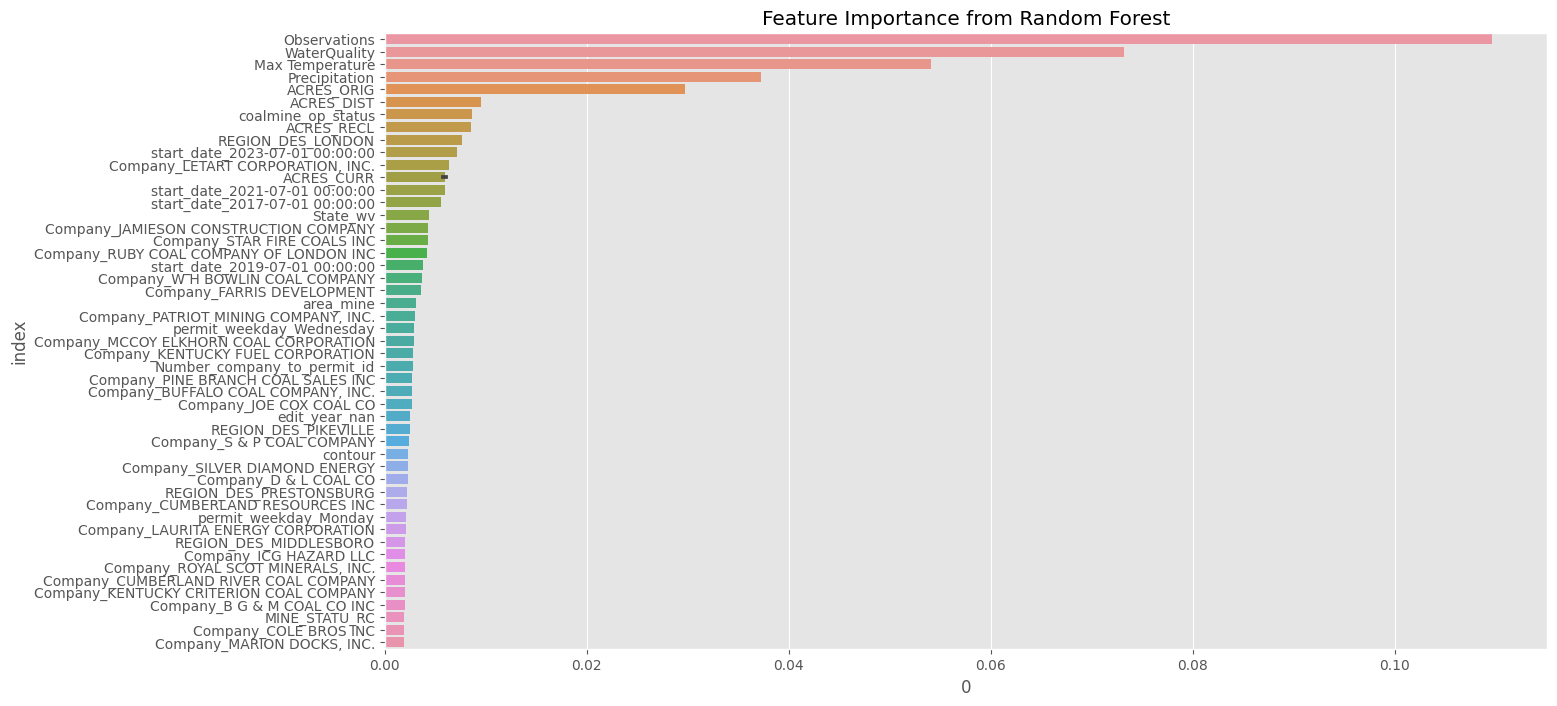

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_importance =rf.feature_importances_

forest_importances = pd.Series(feature_importance, index=selected_columns.columns)
forest_importances = pd.DataFrame(forest_importances)

idx = forest_importances[0].sort_values(ascending = False).head(50).index
forest_importances2 = forest_importances.loc[idx]
data=forest_importances2.reset_index()

plt.style.use('ggplot')
plt.figure(figsize = (15,8))
sns.barplot(x=0, y='index', data=data).set(title='Feature Importance from Random Forest')

In [114]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [115]:
columns = all_mines_encoded.columns
column_to_exclude = ['mine_name','permit_id','trees', 'water', 'snow_and_ice','grass','bare', 'flooded_vegetation', 'built', 'shrub_and_scrub', 'crops']
columns = list(set(columns) - set(column_to_exclude))
selected_columns = all_mines_encoded[columns]

sequence_length=4

features = all_mines_encoded[columns]
target = all_mines_encoded['trees']
X, y, y_index = [], [], []
for i in range(len(features) - sequence_length):
    X.append(features.iloc[i:i + sequence_length].values)
    y.append(target.iloc[i + sequence_length])

X=np.array(X)
y=np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=0)

In [116]:
feature_length = X_train.shape[2]

regressor = Sequential()
#regressor.add(tf.keras.layers.Embedding(input_dim=X_train.shape[2], output_dim=4))

regressor.add(LSTM(units = 50, input_shape=(sequence_length, X_train.shape[2]), return_sequences = True, activation = 'relu'))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(50))
regressor.add(Dropout(0.2))
regressor.add(Dense(1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
1149/1149 [==============================] - 34s 23ms/step - loss: 0.0239
Epoch 2/50
1149/1149 [==============================] - 27s 23ms/step - loss: 0.0170
Epoch 3/50
1149/1149 [==============================] - 27s 23ms/step - loss: 0.0151
Epoch 4/50
1149/1149 [==============================] - 27s 23ms/step - loss: 0.0136
Epoch 5/50
1149/1149 [==============================] - 26s 23ms/step - loss: 0.0125
Epoch 6/50
1149/1149 [==============================] - 26s 23ms/step - loss: 0.0115
Epoch 7/50
1149/1149 [==============================] - 27s 23ms/step - loss: 0.0107
Epoch 8/50
1149/1149 [==============================] - 27s 23ms/step - loss: 0.0099
Epoch 9/50
1149/1149 [==============================] - 27s 23ms/step - loss: 0.0092
Epoch 10/50
1149/1149 [==============================] - 27s 23ms/step - loss: 0.0085
Epoch 11/50
1149/1149 [==============================] - 27s 23ms/step - loss: 0.0079
Epoch 12/50
1149/1149 [==============================] - 27s 23

In [117]:

y_pred = regressor.predict(X)

1437/1437 [==============================] - 15s 9ms/step


In [118]:
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print('\nMean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R^2):', r2)


Mean Squared Error (MSE): 0.004388219548382909
Mean Absolute Error (MAE): 0.03440456451538892
R-squared (R^2): 0.7611067624821463


In [120]:
y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('\nMean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R^2):', r2)

288/288 [==============================] - 3s 9ms/step

Mean Squared Error (MSE): 0.014780401036511816
Mean Absolute Error (MAE): 0.07456685091674757
R-squared (R^2): 0.16769912413545163


In [43]:
file_name = 'all_mines_with_precip_update.csv'
from google.colab import files
df.to_csv(file_name, encoding = 'utf-8-sig')
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>